<a href="https://colab.research.google.com/github/RazvanRotaru/SceneReconstructuin/blob/main/YOLO_Object_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget http://images.cocodataset.org/annotations/stuff_annotations_trainval2017.zip

--2021-04-22 22:14:02--  http://images.cocodataset.org/annotations/stuff_annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.237.83
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.237.83|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1148688564 (1.1G) [application/zip]
Saving to: ‘stuff_annotations_trainval2017.zip.2’

stuff_annotations_t 100%[===================>]   1.07G  68.6MB/s    in 19s     

2021-04-22 22:14:21 (58.6 MB/s) - ‘stuff_annotations_trainval2017.zip.2’ saved [1148688564/1148688564]



In [ ]:
!mkdir -p COCO
!unzip stuff_annotations_trainval2017.zip -d ./COCO

Archive:  stuff_annotations_trainval2017.zip
replace ./COCO/annotations/stuff_train2017_pixelmaps.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
 extracting: ./COCO/annotations/stuff_train2017_pixelmaps.zip  y

replace ./COCO/annotations/stuff_val2017_pixelmaps.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename:  extracting: ./COCO/annotations/stuff_val2017_pixelmaps.zip  
replace ./COCO/annotations/stuff_val2017.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: ./COCO/annotations/stuff_val2017.json  
  inflating: ./COCO/annotations/stuff_train2017.json  
  inflating: ./COCO/annotations/deprecated-challenge2017/val-ids.txt  
  inflating: ./COCO/annotations/deprecated-challenge2017/train-ids.txt  


In [ ]:
%%shell

pip install cython
# Install pycocotools, the version by default in Colab
# has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354
pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-cvk3h7we
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-cvk3h7we
  Created wheel for pycocotools: filename=pycocotools-2.0-cp37-cp37m-linux_x86_64.whl size=263920 sha256=86b3e833fddab853f83d8123a853c67a7646393822d2489209b65eddb829deac
  Stored in directory: /tmp/pip-ephem-wheel-cache-ukkjbkrx/wheels/90/51/41/646daf401c3bc408ff10de34ec76587a9b3ebfac8d21ca5c3a
Successfully built pycocotools
  Found existing installation: pycocotools 2.0
    Uninstalling pycocotools-2.0:
      Successfully uninstalled pycocotools-2.0


In [ ]:
!pip install --upgrade --force-reinstall --no-deps albumentations

  Using cached https://files.pythonhosted.org/packages/03/58/63fb1d742dc42d9ba2800ea741de1f2bc6bb05548d8724aa84794042eaf2/albumentations-0.5.2-py3-none-any.whl
  Found existing installation: albumentations 0.5.2
    Uninstalling albumentations-0.5.2:
      Successfully uninstalled albumentations-0.5.2


In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1" 

In [ ]:
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import random
import os
import cv2
from google.colab.patches import cv2_imshow
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### For visualizing the outputs ###
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

In [ ]:
dataDir='./COCO'
dataType='train'
annFile='{}/annotations/stuff_{}2017.json'.format(dataDir,dataType)

# Initialize the COCO api for instance annotations
coco=COCO(annFile)

dataType2='val'
annFile2='{}/annotations/stuff_{}2017.json'.format(dataDir,dataType2)

# Initialize the COCO api for instance annotations
coco2=COCO(annFile2)


# Load the categories in a variable
catIDs = coco.getCatIds()
cats = coco.loadCats(catIDs)
annsId = coco.getAnnIds(imgIds=[95], iscrowd=None)
print(annsId)
anns = coco.loadAnns(annsId)
print(anns)

print(list(map(lambda x: x['name'], cats)))
print(list(filter(lambda x: x['name'] == 'bridge', cats)))

print(f"train has {len(coco.getImgIds())} elements")
print(f"val has {len(coco2.getImgIds())} elements")
print(len(catIDs))
print(catIDs)

loading annotations into memory...
Done (t=12.33s)
creating index...
index created!
loading annotations into memory...
Done (t=1.25s)
creating index...
index created!
[]
[]
['banner', 'blanket', 'branch', 'bridge', 'building-other', 'bush', 'cabinet', 'cage', 'cardboard', 'carpet', 'ceiling-other', 'ceiling-tile', 'cloth', 'clothes', 'clouds', 'counter', 'cupboard', 'curtain', 'desk-stuff', 'dirt', 'door-stuff', 'fence', 'floor-marble', 'floor-other', 'floor-stone', 'floor-tile', 'floor-wood', 'flower', 'fog', 'food-other', 'fruit', 'furniture-other', 'grass', 'gravel', 'ground-other', 'hill', 'house', 'leaves', 'light', 'mat', 'metal', 'mirror-stuff', 'moss', 'mountain', 'mud', 'napkin', 'net', 'paper', 'pavement', 'pillow', 'plant-other', 'plastic', 'platform', 'playingfield', 'railing', 'railroad', 'river', 'road', 'rock', 'roof', 'rug', 'salad', 'sand', 'sea', 'shelf', 'sky-other', 'skyscraper', 'snow', 'solid-other', 'stairs', 'stone', 'straw', 'structural-other', 'table', 'tent',

Number of images containing all the  classes: 118287
[0.0, 166.0, 258.0, 107.0]
[16.0, 0.0, 624.0, 61.0]
[0.0, 175.0, 640.0, 254.0]
[0.0, 0.0, 640.0, 204.0]
[1.0, 125.0, 639.0, 156.0]


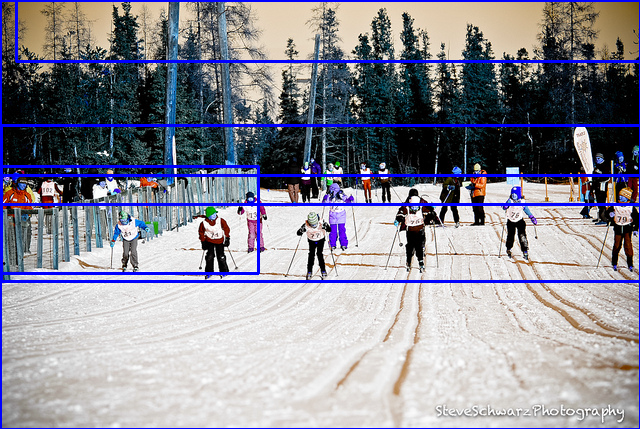

In [ ]:
# Define the classes (out of the 81) which you want to see. Others will not be shown.
filterClasses = ['laptop', 'tv', 'cell phone']

# Fetch class IDs only corresponding to the filterClasses
catIds = coco.getCatIds(catNms=filterClasses) 
# Get all images containing the above Category IDs
imgIds = coco.getImgIds(catIds=catIds)
print("Number of images containing all the  classes:", len(imgIds))

# load and display a random image
img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]
# I = io.imread('{}/images/{}/{}'.format(dataDir,dataType,img['file_name']))/255.0
I = io.imread(img['coco_url'],  plugin='matplotlib')

# print(type(I))
# print(img)
ii = np.array(I)
# print(ii.shape)

annsId = coco.getAnnIds(imgIds=[img['id']], iscrowd=False)
# print(annsId)
anns = coco.loadAnns(annsId)
# print(list(map(lambda x: x.keys(), anns)))
anns = list(filter(lambda x: x['iscrowd'] == 0, anns))
catIDs = list(map(lambda x: x['category_id'], anns))
bboxs = list(map(lambda x: x['bbox'], anns))

cats = coco.loadCats(catIDs)
# print(cats)
# print(list(map(lambda x: x['name'], cats)))
# print(list(map(lambda x: (x['bbox'], list(map(lambda k: k['name'], list(filter(lambda y: y['id'] == x['category_id'], cats))))[0]),anns)))

y = [ a+[b] for a, b in zip(bboxs, catIDs)]
# print(y)

# print(catIDs)
# plt.axis('off')
# plt.imshow(I)
# plt.show()
# coco.showAnns(anns)


for i in anns:
  [x, y, w, h] = i['bbox']
  print([x, y, w, h])
  # [x1, y1, w1, h1] = convert(I.shape, [x, y, w, h])
  # print([x1, y1, w1, h1])
  cv2.rectangle(I, (int(x), int(y)), (int(x+w), int(y+h)), (255,0,0), 2)

cv2_imshow(I)
# plt.show()
# print(type(I))
# print(I.shape)
# print(I.shape[0])
# print(I.shape[1])


# plt.imshow(I); plt.axis('off')
# annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
# anns = coco.loadAnns(annIds)
# coco.showAnns(anns)


In [ ]:
import os, sys, time, datetime, random
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
from PIL import Image, ImageFile
from urllib.request import urlopen
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from tqdm.notebook import tqdm

from torchvision import datasets, transforms
from torch.autograd import Variable

import matplotlib.pyplot as plt
import matplotlib.patches as patches

## Utils

In [ ]:
"""
        (numclasses + 5) * 3 explanation:
- each prediction has a feature vector that contains:
  1) numclasses [dog_prob = 0.2, house_prob = 0.58, tv_prob = 0.3 ...]
  2) +1 - probability of existance of an object
  3) +4 - a bounding box (anchor.x, anchor.y, w, h)
  4) *3 - the number of predicition layers 
"""
def prediction_size(numclasses):
  return (numclasses + 5)
def features_size(numclasses):
  return prediction_size(numclasses) * 3

def iou(boxes1, boxes2):
    """
    Parameters:
        boxes1 (tensor): width and height of the first bounding boxes
        boxes2 (tensor): width and height of the second bounding boxes
    Returns:
        tensor: Intersection over union of the corresponding boxes
    """
    intersection = torch.min(boxes1[..., 0], boxes2[..., 0]) * torch.min(
        boxes1[..., 1], boxes2[..., 1]
    )
    union = (
        boxes1[..., 0] * boxes1[..., 1] + boxes2[..., 0] * boxes2[..., 1] - intersection
    )
    return intersection / union


def intersection_over_union(boxes_preds, boxes_labels, box_format="midpoint"):
    """
    Video explanation of this function:
    https://youtu.be/XXYG5ZWtjj0
    This function calculates intersection over union (iou) given pred boxes
    and target boxes.
    Parameters:
        boxes_preds (tensor): Predictions of Bounding Boxes (BATCH_SIZE, 4)
        boxes_labels (tensor): Correct labels of Bounding Boxes (BATCH_SIZE, 4)
        box_format (str): midpoint/corners, if boxes (x,y,w,h) or (x1,y1,x2,y2)
    Returns:
        tensor: Intersection over union for all examples
    """

    if box_format == "midpoint":
        box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2
        box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
        box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
        box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2
        box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
        box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
        box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
        box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2

    if box_format == "corners":
        box1_x1 = boxes_preds[..., 0:1]
        box1_y1 = boxes_preds[..., 1:2]
        box1_x2 = boxes_preds[..., 2:3]
        box1_y2 = boxes_preds[..., 3:4]
        box2_x1 = boxes_labels[..., 0:1]
        box2_y1 = boxes_labels[..., 1:2]
        box2_x2 = boxes_labels[..., 2:3]
        box2_y2 = boxes_labels[..., 3:4]

    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)

    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)
    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))

    return intersection / (box1_area + box2_area - intersection + 1e-6)


import time
def non_max_suppression(bboxes, iou_threshold, threshold, box_format="corners"):
    """
    Video explanation of this function:
    https://youtu.be/YDkjWEN8jNA
    Does Non Max Suppression given bboxes
    Parameters:
        bboxes (list): list of lists containing all bboxes with each bboxes
        specified as [class_pred, prob_score, x1, y1, x2, y2]
        iou_threshold (float): threshold where predicted bboxes is correct
        threshold (float): threshold to remove predicted bboxes (independent of IoU)
        box_format (str): "midpoint" or "corners" used to specify bboxes
    Returns:
        list: bboxes after performing NMS given a specific IoU threshold
    """

    assert type(bboxes) == list

    bboxes = [box for box in bboxes if box[1] > threshold]
    bboxes = sorted(bboxes, key=lambda x: x[1], reverse=True)
    bboxes_after_nms = []

    while bboxes:
        chosen_box = bboxes.pop(0)

        start_time = time.time()
        bboxes = [
            box
            for box in bboxes
            if box[0] != chosen_box[0]
            or intersection_over_union(
                torch.tensor(chosen_box[2:]),
                torch.tensor(box[2:]),
                box_format=box_format,
            )
            < iou_threshold
        ]
        print(f"bbox {(time.time() - start_time)} seconds for {len(bboxes)} bboxes")

        bboxes_after_nms.append(chosen_box)

    return bboxes_after_nms

def mean_average_precision(
    pred_boxes, true_boxes, iou_threshold=0.5, box_format="midpoint", num_classes=20
):
    """
    Video explanation of this function:
    https://youtu.be/FppOzcDvaDI
    This function calculates mean average precision (mAP)
    Parameters:
        pred_boxes (list): list of lists containing all bboxes with each bboxes
        specified as [train_idx, class_prediction, prob_score, x1, y1, x2, y2]
        true_boxes (list): Similar as pred_boxes except all the correct ones
        iou_threshold (float): threshold where predicted bboxes is correct
        box_format (str): "midpoint" or "corners" used to specify bboxes
        num_classes (int): number of classes
    Returns:
        float: mAP value across all classes given a specific IoU threshold
    """

    # list storing all AP for respective classes
    average_precisions = []

    # used for numerical stability later on
    epsilon = 1e-6

    for c in range(num_classes):
        detections = []
        ground_truths = []

        # Go through all predictions and targets,
        # and only add the ones that belong to the
        # current class c
        for detection in pred_boxes:
            if detection[1] == c:
                detections.append(detection)

        for true_box in true_boxes:
            if true_box[1] == c:
                ground_truths.append(true_box)

        # find the amount of bboxes for each training example
        # Counter here finds how many ground truth bboxes we get
        # for each training example, so let's say img 0 has 3,
        # img 1 has 5 then we will obtain a dictionary with:
        # amount_bboxes = {0:3, 1:5}
        amount_bboxes = Counter([gt[0] for gt in ground_truths])

        # We then go through each key, val in this dictionary
        # and convert to the following (w.r.t same example):
        # ammount_bboxes = {0:torch.tensor[0,0,0], 1:torch.tensor[0,0,0,0,0]}
        for key, val in amount_bboxes.items():
            amount_bboxes[key] = torch.zeros(val)

        # sort by box probabilities which is index 2
        detections.sort(key=lambda x: x[2], reverse=True)
        TP = torch.zeros((len(detections)))
        FP = torch.zeros((len(detections)))
        total_true_bboxes = len(ground_truths)

        # If none exists for this class then we can safely skip
        if total_true_bboxes == 0:
            continue

        for detection_idx, detection in enumerate(detections):
            # Only take out the ground_truths that have the same
            # training idx as detection
            ground_truth_img = [
                bbox for bbox in ground_truths if bbox[0] == detection[0]
            ]

            num_gts = len(ground_truth_img)
            best_iou = 0

            for idx, gt in enumerate(ground_truth_img):
                iou = intersection_over_union(
                    torch.tensor(detection[3:]),
                    torch.tensor(gt[3:]),
                    box_format=box_format,
                )

                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = idx

            if best_iou > iou_threshold:
                # only detect ground truth detection once
                if amount_bboxes[detection[0]][best_gt_idx] == 0:
                    # true positive and add this bounding box to seen
                    TP[detection_idx] = 1
                    amount_bboxes[detection[0]][best_gt_idx] = 1
                else:
                    FP[detection_idx] = 1

            # if IOU is lower then the detection is a false positive
            else:
                FP[detection_idx] = 1

        TP_cumsum = torch.cumsum(TP, dim=0)
        FP_cumsum = torch.cumsum(FP, dim=0)
        recalls = TP_cumsum / (total_true_bboxes + epsilon)
        precisions = TP_cumsum / (TP_cumsum + FP_cumsum + epsilon)
        precisions = torch.cat((torch.tensor([1]), precisions))
        recalls = torch.cat((torch.tensor([0]), recalls))
        # torch.trapz for numerical integration
        average_precisions.append(torch.trapz(precisions, recalls))

    return sum(average_precisions) / len(average_precisions)


def plot_image(image, boxes):
    """Plots predicted bounding boxes on the image"""
    cmap = plt.get_cmap("tab20b")
    class_labels = COCO_LABELS if DATASET=='COCO' else PASCAL_CLASSES
    colors = [cmap(i) for i in np.linspace(0, 1, len(class_labels))]
    im = np.array(image)
    height, width, _ = im.shape

    # Create figure and axes
    fig, ax = plt.subplots(1)
    # Display the image
    ax.imshow(im)

    # box[0] is x midpoint, box[2] is width
    # box[1] is y midpoint, box[3] is height

    # Create a Rectangle patch
    for box in boxes:
        assert len(box) == 6, "box should contain class pred, confidence, x, y, width, height"
        class_pred = box[0]
        box = box[2:]
        upper_left_x = box[0] - box[2] / 2
        upper_left_y = box[1] - box[3] / 2
        rect = patches.Rectangle(
            (upper_left_x * width, upper_left_y * height),
            box[2] * width,
            box[3] * height,
            linewidth=2,
            edgecolor=colors[int(class_pred)],
            facecolor="none",
        )
        # Add the patch to the Axes
        ax.add_patch(rect)
        plt.text(
            upper_left_x * width,
            upper_left_y * height,
            s=class_labels[int(class_pred)],
            color="white",
            verticalalignment="top",
            bbox={"color": colors[int(class_pred)], "pad": 0},
        )

    plt.show()


def get_evaluation_bboxes(
    loader,
    model,
    iou_threshold,
    anchors,
    threshold,
    box_format="midpoint",
    device="cuda",
):
    # make sure model is in eval before get bboxes
    model.eval()
    train_idx = 0
    all_pred_boxes = []
    all_true_boxes = []

    limit = 50
    index = 0
    for batch_idx, (x, labels) in enumerate(tqdm(loader)):
        index += 1
        if index >= limit:
          break
          
        x = x.to(device)

        with torch.no_grad():
            predictions = model(x)

        batch_size = x.shape[0]
        bboxes = [[] for _ in range(batch_size)]
        for i in range(3):
            S = predictions[i].shape[2]
            anchor = torch.tensor([*anchors[i]]).to(device) * S
            boxes_scale_i = cells_to_bboxes(
                predictions[i], anchor, S=S, is_preds=True
            )
            for idx, (box) in enumerate(boxes_scale_i):
                bboxes[idx] += box

        # we just want one bbox for each label, not one for each scale
        true_bboxes = cells_to_bboxes(
            labels[2], anchor, S=S, is_preds=False
        )

        for idx in range(batch_size):
            start_time = time.time()
            nms_boxes = non_max_suppression(
                bboxes[idx],
                iou_threshold=iou_threshold,
                threshold=threshold,
                box_format=box_format,
            )
            print(f"non max supression takes {(time.time() - start_time)} seconds for {len(bboxes[idx])} bboxes")
            print(bboxes[idx])

            for nms_box in nms_boxes:
                all_pred_boxes.append([train_idx] + nms_box)

            for box in true_bboxes[idx]:
                if box[1] > threshold:
                    all_true_boxes.append([train_idx] + box)

            train_idx += 1

    model.train()
    return all_pred_boxes, all_true_boxes


def cells_to_bboxes(predictions, anchors, S, is_preds=True):
    """
    Scales the predictions coming from the model to
    be relative to the entire image such that they for example later
    can be plotted or.
    INPUT:
    predictions: tensor of size (N, 3, S, S, num_classes+5)
    anchors: the anchors used for the predictions
    S: the number of cells the image is divided in on the width (and height)
    is_preds: whether the input is predictions or the true bounding boxes
    OUTPUT:
    converted_bboxes: the converted boxes of sizes (N, num_anchors, S, S, 1+5) with class index,
                      object score, bounding box coordinates
    """
    BATCH_SIZE = predictions.shape[0]
    num_anchors = len(anchors)
    box_predictions = predictions[..., 1:5]
    if is_preds:
        anchors = anchors.reshape(1, len(anchors), 1, 1, 2)
        box_predictions[..., 0:2] = torch.sigmoid(box_predictions[..., 0:2])
        box_predictions[..., 2:] = torch.exp(box_predictions[..., 2:]) * anchors
        scores = torch.sigmoid(predictions[..., 0:1])
        best_class = torch.argmax(predictions[..., 5:], dim=-1).unsqueeze(-1)
    else:
        scores = predictions[..., 0:1]
        best_class = predictions[..., 5:6]

    cell_indices = (
        torch.arange(S)
        .repeat(predictions.shape[0], 3, S, 1)
        .unsqueeze(-1)
        .to(predictions.device)
    )
    x = 1 / S * (box_predictions[..., 0:1] + cell_indices)
    y = 1 / S * (box_predictions[..., 1:2] + cell_indices.permute(0, 1, 3, 2, 4))
    w_h = 1 / S * box_predictions[..., 2:4]
    converted_bboxes = torch.cat((best_class, scores, x, y, w_h), dim=-1).reshape(BATCH_SIZE, num_anchors * S * S, 6)
    return converted_bboxes.tolist()

def check_class_accuracy(model, loader, threshold):
    model.eval()
    tot_class_preds, correct_class = 0, 0
    tot_noobj, correct_noobj = 0, 0
    tot_obj, correct_obj = 0, 0

    for idx, (x, y) in enumerate(tqdm(loader)):
        x = x.to(DEVICE)
        with torch.no_grad():
            out = model(x)

        for i in range(3):
            y[i] = y[i].to(DEVICE)
            obj = y[i][..., 0] == 1 # in paper this is Iobj_i
            noobj = y[i][..., 0] == 0  # in paper this is Iobj_i

            correct_class += torch.sum(
                torch.argmax(out[i][..., 5:][obj], dim=-1) == y[i][..., 5][obj]
            )
            tot_class_preds += torch.sum(obj)

            obj_preds = torch.sigmoid(out[i][..., 0]) > threshold
            correct_obj += torch.sum(obj_preds[obj] == y[i][..., 0][obj])
            tot_obj += torch.sum(obj)
            correct_noobj += torch.sum(obj_preds[noobj] == y[i][..., 0][noobj])
            tot_noobj += torch.sum(noobj)

    print(f"Class accuracy is: {(correct_class/(tot_class_preds+1e-16))*100:2f}%")
    print(f"No obj accuracy is: {(correct_noobj/(tot_noobj+1e-16))*100:2f}%")
    print(f"Obj accuracy is: {(correct_obj/(tot_obj+1e-16))*100:2f}%")
    model.train()


def get_mean_std(loader):
    # var[X] = E[X**2] - E[X]**2
    channels_sum, channels_sqrd_sum, num_batches = 0, 0, 0

    for data, _ in tqdm(loader):
        channels_sum += torch.mean(data, dim=[0, 2, 3])
        channels_sqrd_sum += torch.mean(data ** 2, dim=[0, 2, 3])
        num_batches += 1

    mean = channels_sum / num_batches
    std = (channels_sqrd_sum / num_batches - mean ** 2) ** 0.5

    return mean, std


def save_checkpoint(model, optimizer, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)


def load_checkpoint(checkpoint_file, model, optimizer, lr):
    print("=> Loading checkpoint")
    checkpoint = torch.load(checkpoint_file, map_location=DEVICE)
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

    # If we don't do this then it will just have learning rate of old checkpoint
    # and it will lead to many hours of debugging \:
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr


def get_loaders(train_ann_path, test_ann_path):
    train_dataset = YOLODataset(
        annFile=train_ann_path,
        transform=train_transforms,
        S=[IMAGE_SIZE // 32, IMAGE_SIZE // 16, IMAGE_SIZE // 8],
        anchors=ANCHORS,
    )
    test_dataset = YOLODataset(
        annFile=test_ann_path,
        transform=test_transforms,
        S=[IMAGE_SIZE // 32, IMAGE_SIZE // 16, IMAGE_SIZE // 8],
        anchors=ANCHORS,
    )
    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
        shuffle=True,
        drop_last=False,
    )
    test_loader = DataLoader(
        dataset=test_dataset,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
        shuffle=False,
        drop_last=False,
    )

    # train_eval_dataset = YOLODataset(
    #     annFile=train_ann_path,
    #     transform=test_transforms,
    #     S=[IMAGE_SIZE // 32, IMAGE_SIZE // 16, IMAGE_SIZE // 8],
    #     anchors=ANCHORS,
    # )
    # train_eval_loader = DataLoader(
    #     dataset=train_eval_dataset,
    #     batch_size=BATCH_SIZE,
    #     num_workers=NUM_WORKERS,
    #     pin_memory=PIN_MEMORY,
    #     shuffle=False,
    #     drop_last=False,
    # )

    return train_loader, test_loader, None

def plot_couple_examples(model, loader, thresh, iou_thresh, anchors):
    model.eval()
    x, y = next(iter(loader))
    x = x.to("cuda")
    with torch.no_grad():
        out = model(x)
        bboxes = [[] for _ in range(x.shape[0])]
        for i in range(3):
            batch_size, A, S, _, _ = out[i].shape
            anchor = anchors[i]
            boxes_scale_i = cells_to_bboxes(
                out[i], anchor, S=S, is_preds=True
            )
            for idx, (box) in enumerate(boxes_scale_i):
                bboxes[idx] += box

        model.train()

    for i in range(batch_size):
        nms_boxes = non_max_suppression(
            bboxes[i], iou_threshold=iou_thresh, threshold=thresh, box_format="midpoint",
        )
        plot_image(x[i].permute(1,2,0).detach().cpu(), nms_boxes)

## Model

In [ ]:
#Confing

"""
Tuple of (out_channels, kernel_size, stride)

"B" is a residual block of 2 x Conv Layers + 1 x Residual Layer
List of [RESIDUAL_BLOCK, number_of_repeats]

"S" is a scale prediction branch
"U" is a upsampling layer
"""
config = [
  
  #Start of Darknet-53 architecture
  (32, 3, 1),
  (64, 3, 2),
  ["B", 1],
  (128, 3, 2),
  ["B", 2],
  (256, 3, 2),
  ["B", 8],
  (512, 3, 2),
  ["B", 8],
  (1024, 3, 2),
  ["B", 4],
  #End of Darkent-53 architecture

  (512, 1, 1),
  (1024, 3, 1),
  
  "S", #Scale prediction branch of size 13x13
  
  (256, 1, 1),
  "U",
  (256, 1, 1),
  (512, 3, 1),
  
  "S", #Scale prediction branch of size 26x26

  (128, 1, 1),
  "U",
  (128, 1, 1),
  (256, 3, 1),

  "S", #Scale prediction branch of size 52x52
]

In [ ]:
#Model

class CNNBlock(nn.Module):
  def __init__(self, in_channels, out_channels, batchN_act=True, **kwargs):
    super().__init__()
    self.conv = nn.Conv2d(in_channels, out_channels, bias=not batchN_act, **kwargs)
    self.batchN = nn.BatchNorm2d(out_channels)
    self.relu = nn.LeakyReLU(0.1)
    self.use_batchN_act = batchN_act

  def forward(self, x):
    if self.use_batchN_act:
      return self.relu(self.batchN(self.conv(x)))
    else:
      return self.conv(x)

class ResidualBlock(nn.Module):
  def __init__(self, in_channels, use_residual=True, repeats=1):
    super().__init__()
    self.layers = nn.ModuleList()
    for repeat in range(repeats):
      self.layers += [
        nn.Sequential(
          CNNBlock(in_channels, in_channels//2, kernel_size=1),
          CNNBlock(in_channels//2, in_channels, kernel_size=3, padding=1),
        )
      ]

    self.use_residual = use_residual
    self.repeats = repeats

  def forward(self, x):
    for layer in self.layers:
      x = layer(x) + x if self.use_residual else layer(x)
    return x

class ScalePrediction(nn.Module):
  def __init__(self, in_channels, num_classes):
    super().__init__()
    self.pred = nn.Sequential(
        CNNBlock(in_channels, 2*in_channels, kernel_size=3, padding=1),
        CNNBlock(2*in_channels, features_size(num_classes), batchN_act=False, kernel_size=1),
    )
    self.num_classes = num_classes

  def forward(self, x):
    """
    input batch_size: (N x DIM x DIM x channels)
    output batch_size (N x 3 x DIM x DIM x prediction_size)
      DIM can be: 13, 26, 52
      prediction_size is: num_classes + 5
    """
    return (
        self.pred(x)
        .reshape(x.shape[0], 3, prediction_size(self.num_classes), x.shape[2], x.shape[3])
        .permute(0, 1, 3, 4, 2)
    )

class YOLOv3(nn.Module):
  def __init__(self, in_channels=3, num_classes=20):
    super().__init__()
    super().__init__()
    self.num_classes = num_classes
    self.in_channels = in_channels
    self.layers = self._create_layers()

  def forward(self, x):
    outputs = []
    route_conn = []

    for layer in self.layers:
      if isinstance(layer, ScalePrediction):
        outputs.append(layer(x))
        continue

      x = layer(x)

      if isinstance(layer, ResidualBlock) and layer.repeats == 8:
        route_conn.append(x)

      elif isinstance(layer, nn.Upsample):
        x = torch.cat([x, route_conn[-1]], dim = 1)
        route_conn.pop()

    return outputs

  def _create_layers(self):
    layers = nn.ModuleList()
    in_channels = self.in_channels

    for module in config:
      if isinstance(module, tuple):
        out_channels, kernel_size, stride = module
        layers.append(
          CNNBlock(
              in_channels,
              out_channels,
              kernel_size=kernel_size,
              stride=stride,
              padding=1 if kernel_size==3 else 0,
          )
        )
        in_channels = out_channels

      elif isinstance(module, list):
        repeats = module[1]
        layers.append(ResidualBlock(in_channels, repeats=repeats))
      
      elif isinstance(module, str):
        if module == "S":
          layers += [
            ResidualBlock(in_channels, use_residual=False, repeats=1),
            CNNBlock(in_channels, in_channels//2, kernel_size=1),
            ScalePrediction(in_channels//2, num_classes=self.num_classes),
          ]
          in_channels = in_channels // 2
        elif module == "U":
          layers.append(nn.Upsample(scale_factor=2))
          in_channels = in_channels * 3

    return layers

In [ ]:
x = 1
y = [2, 2]
y.insert(0, x)
y.append(x)
y = [a/3 for a in y]
print(y)

[0.3333333333333333, 0.6666666666666666, 0.6666666666666666, 0.3333333333333333]


## Dataset

In [ ]:
list1 = [1, 2, 3]

list2 = [4, 5, 6]


sum_list = [ [a]+[b] for a, b in zip(list1, list2)]


print(sum_list)


y = [2, 3, 4, 5]
# y = [[a / 2] + [b + 2] for a, b in y]
y[0] /= 2
print(y)

[[1, 4], [2, 5], [3, 6]]
[1.0, 3, 4, 5]


In [ ]:
def convert(size, box):
    dw = 1./(size[0])
    dh = 1./(size[1])
    x = (box[0] + box[1])/2.0 - 1
    y = (box[2] + box[3])/2.0 - 1
    w = box[1] - box[0]
    h = box[3] - box[2]
    x = x*dw
    w = w*dw
    y = y*dh
    h = h*dh
    return (x,y,w,h)

def check_bbox(bbox):
    """Check if bbox boundaries are in range 0, 1 and minimums are lesser then maximums"""
   #my added block 
    bbox=list(bbox)
    for i in range(4):
      if (bbox[i]<0) :
        bbox[i]=0
      elif (bbox[i]>1) :
        bbox[i]=1
    bbox=tuple(bbox)

In [ ]:
#Dataset

ImageFile.LOAD_TRUNCTAED_IMAGES = True

class YOLODataset(Dataset):
  def __init__(
      self,
      annFile,
      anchors,
      image_size=416, #default value in YOLOv3
      S=[13, 26, 52], #grid sizes
      C=20,           #classes
      transform=None,
  ):
    self.annFile = annFile
    self.coco = COCO(annFile)
    catIds = self.coco.getCatIds(catNms=COCO_LABELS) 
    self.ids = self.coco.getImgIds(catIds=catIds)
    # print(f"IDs are: {self.ids} \n of {len(self.catIds)} categories")
    print(f"Dataset has {len(self.ids)} elements in {annFile}")
    self.S = S
    self.anchors = torch.tensor(anchors[0] + anchors[1] + anchors[2])
    self.num_anchors = self.anchors.shape[0]
    self.num_anchors_per_scale = self.num_anchors // 3
    self.C = C
    self.ignore_iou_threshold = 0.5
    self.transform = transform

  def __len__(self):
    return len(self.ids)
  
  def __getitem__(self, index):
    ind = index if index < len(self.ids) else -1
    # print(f"current index {index} => {ind}")
    img_path = self.coco.loadImgs(self.ids[ind])[0]
    
    image = np.array(Image.open(urlopen(img_path['coco_url'])).convert('RGB'))

    annsId = self.coco.getAnnIds(imgIds=[img_path['id']], iscrowd=False)
    anns = self.coco.loadAnns(annsId)

    catIDs = list(map(lambda x: x['category_id'] - 92, anns))
    bbs = list(map(lambda x: x['bbox'], anns))
    shape = image.shape
    # print(f"initial bbox {bbs}")
    # print(f"shape {shape}")
    bbs = [
           [
            (x[0] + x[2]/2)/shape[1],
            (x[1] + x[3]/2)/shape[0],
            (x[2] - 1)/shape[1],
            (x[3] - 1)/shape[0]
            ] for x in bbs
           ]

    
    for b in bbs:
      if b[2] == 0 or b[3] == 0:
        bbs.remove(b)

    # for b in bbs:
    #   if (b[0] + b[2] / 2) <= (b[0] - b[2] / 2):
    #     b[2] += 0.1
    #     b[0] += 0.05
    #   if (b[1] + b[3] / 2) <= (b[1] - b[3] / 2):
    #     b[3] += 0.1
    #     b[1] += 0.05

    # bbs = convert(shape, bbs)
    bboxes = [a+[b] for a, b in zip(bbs, catIDs)]
    for i in range(len(bboxes)):
      for j in range(4):
        if (bboxes[i][j]<0) :
          bboxes[i][j]=0
        elif (bboxes[i][j]>1) :
          bboxes[i][j]=1
    # print(bboxes)
    # print(image)
    if self.transform:
      # print(f"given bboxes {bboxes}")
      augmentations = self.transform(image=image, bboxes=bboxes)
      image = augmentations["image"]
      bboxes = augmentations["bboxes"]

    targets = [torch.zeros((self.num_anchors // 3, S, S, 6)) for S in self.S]
    #6 is for [prob_of_object, x, y, w, h, class]

    for box in bboxes:
      iou_anchors = iou(torch.tensor(box[2:4]), self.anchors)
      anchor_indices = iou_anchors.argsort(descending=True, dim=0)
      x, y, w, h, c = box
      has_anchor = [False, #scale 1
                    False, #scale 2
                    False, #scale 3
                   ]
      for anchor_idx in anchor_indices:
        scale_idx = anchor_idx // self.num_anchors_per_scale
        anchor_on_scale = anchor_idx % self.num_anchors_per_scale
        S = self.S[scale_idx]
        i, j = int(S*y), int(S*x)
        anchor_taken = targets[scale_idx][anchor_on_scale, i, j, 0] #prob of object

        if not anchor_taken and not has_anchor[scale_idx]:
          targets[scale_idx][anchor_on_scale, i, j, 0] = 1 #make prediction
          x_cell, y_cell = S*x - j, S*y - i
          w_cell, h_cell = S*w, S*h
          l = [x_cell, y_cell, w_cell, h_cell]
          l = [max(x, 1) for x in l]
          box_coord = torch.tensor(l)
          targets[scale_idx][anchor_on_scale, i, j, 1:5] = box_coord
          targets[scale_idx][anchor_on_scale, i, j, 5] = int(c)

        elif not anchor_taken and iou_anchors[anchor_idx] > self.ignore_iou_threshold:
          i = max(i, 1)
          j = max(j, 1)
          targets[scale_idx][anchor_on_scale, i, j, 0] = -1 #ignore prediction

    # print(f"given bbox {check_bbox(target)}")
    return image, tuple(targets)

## Loss

In [ ]:
class YOLOLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        self.bce = nn.BCEWithLogitsLoss()
        self.entropy = nn.CrossEntropyLoss()
        self.sigmoid = nn.Sigmoid()

        # Constants signifying how much to pay for each respective part of the loss
        self.lambda_class = 1
        self.lambda_noobj = 10
        self.lambda_obj = 1
        self.lambda_box = 10

    def forward(self, predictions, target, anchors):
        # Check where obj and noobj (we ignore if target == -1)
        obj = target[..., 0] == 1  # in paper this is Iobj_i
        noobj = target[..., 0] == 0  # in paper this is Inoobj_i

        # ======================= #
        #   FOR NO OBJECT LOSS    #
        # ======================= #

        no_object_loss = self.bce(
            (predictions[..., 0:1][noobj]), (target[..., 0:1][noobj]),
        )

        # ==================== #
        #   FOR OBJECT LOSS    #
        # ==================== #

        anchors = anchors.reshape(1, 3, 1, 1, 2)
        box_preds = torch.cat([self.sigmoid(predictions[..., 1:3]), torch.exp(predictions[..., 3:5]) * anchors], dim=-1)
        ious = intersection_over_union(box_preds[obj], target[..., 1:5][obj]).detach()
        object_loss = self.mse(self.sigmoid(predictions[..., 0:1][obj]), ious * target[..., 0:1][obj])

        # ======================== #
        #   FOR BOX COORDINATES    #
        # ======================== #

        predictions[..., 1:3] = self.sigmoid(predictions[..., 1:3])  # x,y coordinates
        target[..., 3:5] = torch.log(
            (1e-16 + target[..., 3:5] / anchors)
        )  # width, height coordinates
        box_loss = self.mse(predictions[..., 1:5][obj], target[..., 1:5][obj])

        # ================== #
        #   FOR CLASS LOSS   #
        # ================== #

        class_loss = self.entropy(
            (predictions[..., 5:][obj]), (target[..., 5][obj].long()),
        )

        #print("__________________________________")
        #print(self.lambda_box * box_loss)
        #print(self.lambda_obj * object_loss)
        #print(self.lambda_noobj * no_object_loss)
        #print(self.lambda_class * class_loss)
        #print("\n")

        return (
            self.lambda_box * box_loss
            + self.lambda_obj * object_loss
            + self.lambda_noobj * no_object_loss
            + self.lambda_class * class_loss
        )

## Config

In [ ]:
import albumentations as A
import cv2
import torch

from albumentations.pytorch import ToTensorV2

DATASET = 'COCO'
# PATH_TO_GDRIVE = '/gdrive/My Drive/'
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
NUM_WORKERS = 2
BATCH_SIZE = 16
IMAGE_SIZE = 416
NUM_CLASSES = 92
LEARNING_RATE = 1e-5
WEIGHT_DECAY = 1e-4
NUM_EPOCHS = 100
CONF_THRESHOLD = 0.05
MAP_IOU_THRESH = 0.5
NMS_IOU_THRESH = 0.45

S = [IMAGE_SIZE // 32, IMAGE_SIZE // 16, IMAGE_SIZE // 8]
PIN_MEMORY = False
LOAD_MODEL = False
SAVE_MODEL = False
CHECKPOINT_FILE = "checkpoint.pth.tar"
ANN_DIR = DATASET + "/annotations/"
# IMG_DIR = DATASET + "/images/"
# LABEL_DIR = DATASET + "/labels/"

# print(IMG_DIR)
# print(len([name for name in os.listdir(IMG_DIR) if os.path.isfile(os.path.join(IMG_DIR, name))]))

ANCHORS = [
    [(0.28, 0.22), (0.38, 0.48), (0.9, 0.78)],
    [(0.07, 0.15), (0.15, 0.11), (0.14, 0.29)],
    [(0.02, 0.03), (0.04, 0.07), (0.08, 0.06)],
]  # Note these have been rescaled to be between [0, 1]


scale = 1.1
train_transforms = A.Compose(
    [
        A.LongestMaxSize(max_size=int(IMAGE_SIZE * scale)),
        A.PadIfNeeded(
            min_height=int(IMAGE_SIZE * scale),
            min_width=int(IMAGE_SIZE * scale),
            border_mode=cv2.BORDER_CONSTANT,
        ),
        A.RandomCrop(width=IMAGE_SIZE, height=IMAGE_SIZE),
        A.ColorJitter(brightness=0.6, contrast=0.6, saturation=0.6, hue=0.6, p=0.4),
        A.OneOf(
            [
                A.ShiftScaleRotate(
                    rotate_limit=20, p=0.5, border_mode=cv2.BORDER_CONSTANT
                ),
                A.IAAAffine(shear=15, p=0.5, mode="constant"),
            ],
            p=1.0,
        ),
        A.HorizontalFlip(p=0.5),
        A.Blur(p=0.1),
        A.CLAHE(p=0.1),
        A.Posterize(p=0.1),
        A.ToGray(p=0.1),
        A.ChannelShuffle(p=0.05),
        A.Normalize(mean=[0, 0, 0], std=[1, 1, 1], max_pixel_value=255,),
        ToTensorV2(),
    ],
    bbox_params=A.BboxParams(format="yolo", min_visibility=0.4, label_fields=[],),
)
test_transforms = A.Compose(
    [
        A.LongestMaxSize(max_size=IMAGE_SIZE),
        A.PadIfNeeded(
            min_height=IMAGE_SIZE, min_width=IMAGE_SIZE, border_mode=cv2.BORDER_CONSTANT
        ),
        A.Normalize(mean=[0, 0, 0], std=[1, 1, 1], max_pixel_value=255,),
        ToTensorV2(),
    ],
    bbox_params=A.BboxParams(format="yolo", min_visibility=0.4, label_fields=[]),
)

COCO_LABELS = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck',
 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat',
 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella',
 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat',
 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot',
 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table',
 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven',
 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
 'toothbrush']

## Train

In [ ]:
#Train

torch.backends.cudnn.benchmark = True

def train_fn(train_loader, model, optimizer, loss_fn, scaler, scaled_anchors):
  # print("setting loop")
  loop = tqdm(train_loader, leave=True)
  losses = []

  # print(train_loadedr)
  # print(f"setting loop batches\n")
  # print(loop[0])
  for batch_idx, (x, y) in enumerate(loop):
    # print(f"setting batch {batch_idx}")
    x = x.to(DEVICE)
    y0, y1, y2 = (
        y[0].to(DEVICE),
        y[1].to(DEVICE),
        y[2].to(DEVICE),
    )

    # print("computing loss")
    with torch.cuda.amp.autocast():
        out = model(x)
        loss = (
            loss_fn(out[0], y0, scaled_anchors[0])
            + loss_fn(out[1], y1, scaled_anchors[1])
            + loss_fn(out[2], y2, scaled_anchors[2])
        )

    # print("backprop")
    losses.append(loss.item())
    optimizer.zero_grad()
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()

    # print("update progres bar")
    # update progress bar
    mean_loss = sum(losses) / len(losses)
    loop.set_postfix(loss=mean_loss)

def main():
  model = YOLOv3(num_classes=NUM_CLASSES).to(DEVICE)
  optimizer = optim.Adam(
      model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY,
  )
  loss_fn = YOLOLoss()
  scaler = torch.cuda.amp.GradScaler()
  # print("getting loaders")
  train_loader, test_loader, _ = get_loaders(
      train_ann_path=ANN_DIR+"stuff_train2017.json", test_ann_path=ANN_DIR+"stuff_val2017.json"
  )
  # print("loading model")
  if LOAD_MODEL:
    load_checkpoint(
        CHECKPOINT_FILE, model, optimizer, LEARNING_RATE
    )

  # print("setting anchores")
  scaled_anchors = (
      torch.tensor(ANCHORS)
      * torch.tensor(S).unsqueeze(1).unsqueeze(2).repeat(1, 3, 2)
  ).to(DEVICE)

  # print("starting")
  for epoch in range(NUM_EPOCHS):
    print(f"train {epoch}")
    train_fn(train_loader, model, optimizer, loss_fn, scaler, scaled_anchors)

    if SAVE_MODEL:
      save_checkpoint(model, optimizer)

    if epoch > 0 and epoch % 3 == 0:
      check_class_accuracy(model, test_loader, threshold=CONF_THRESHOLD)
      pred_boxes, true_boxes = get_evaluation_bboxes(
          test_loader,
          model,
          iou_threshold=NMS_IOU_THRESH,
          anchors=ANCHORS,
          threshold=CONF_THRESHOLD,
      )
      mapval = mean_average_precision(
          pred_boxes,
          true_boxes,
          iou_threshold=MAP_IOU_THRESH,
          box_format="midpoint",
          num_classes=NUM_CLASSES,
      )
      print(f"MAP: {mapval.item()}")
      model.train()

## Run

In [ ]:
# torch.cuda.empty_cache()
!export CUDA_LAUNCH_BLOCKING=1
main()
#halts on enumerate(tqdm)

/usr/local/lib/python3.7/dist-packages/torch/cuda/amp/grad_scaler.py:116: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


loading annotations into memory...
Done (t=12.13s)
creating index...
index created!
Dataset has 118287 elements in COCO/annotations/stuff_train2017.json
loading annotations into memory...
Done (t=0.42s)
creating index...
index created!
Dataset has 5000 elements in COCO/annotations/stuff_val2017.json
train 0


/usr/local/lib/python3.7/dist-packages/torch/cuda/amp/autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


RuntimeError: ignored